# EDA

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
df = pd.read_csv("Datathon 2024 - Reto Hey - Dataset Público - Sheet1.csv")
df['tweet'].iloc[7]

'Muchas gracias 😊'

## Wordcloud

### Removing Emojis

In [20]:
# Removing emojis as first attempt to create wordloud

def extract_emojis(text):
    return ''.join(char for char in text if char in emoji.UNICODE_EMOJI['en'])

def remove_emojis(text):
    return emoji.replace_emoji(text, '')

def remove_stopwords(text):
    words = word_tokenize(text, language='spanish')
    return ' '.join([word.lower() for word in words if word.lower() not in stopwords.words('spanish')])

def clean_text(df):
    df1 = df.copy()
    df1['clean_tweet'] = df1['tweet'].apply(remove_emojis)
    df1['clean_tweet'] = df1['clean_tweet'].str.rstrip()
    df1['clean_tweet'] = df1['clean_tweet'].str.replace(r'\s+', ' ', regex=True)
    df1['clean_tweet'] = df1['clean_tweet'].apply(remove_stopwords)
    return df1

In [21]:
df1 = clean_text(df)
df1['clean_tweet'].iloc[7]

'muchas gracias'

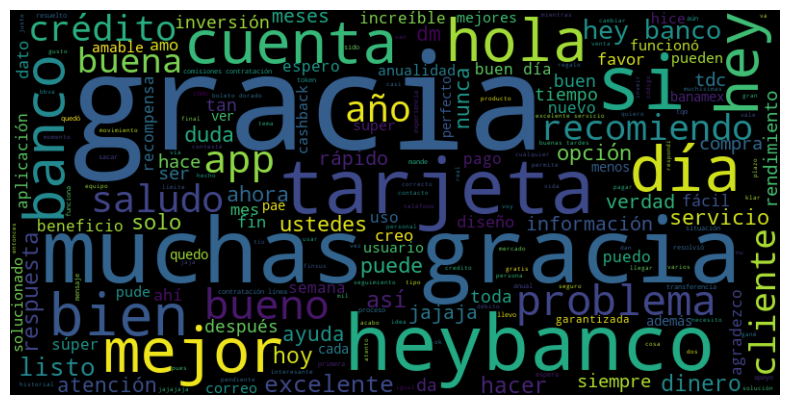

In [22]:
# Join all text in one string
text = ' '.join(df1['clean_tweet'].tolist())

# Wordcloud
wordcloud = wordcloud.WordCloud(width=800, height=400).generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()